In [1]:
import os
import json
import pickle
import numpy as np
import pandas as pd
from pathlib import Path

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler, MinMaxScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from category_encoders.leave_one_out import LeaveOneOutEncoder
import matplotlib.pyplot as plt

pd.set_option("display.max_columns", 200)
pd.set_option("display.width", 200)


In [2]:
DATA_PATH = "crop_yield.csv"

COLS = {
    "region": "Region",
    "soil": "Soil_Type",
    "crop": "Crop",
    "rain": "Rainfall_mm",
    "temp": "Temperature_Celsius",
    "fert": "Fertilizer_Used",
    "irr": "Irrigation_Used",
    "weather": "Weather_Condition",
    "days": "Days_to_Harvest",
    "target": "Yield_tons_per_hectare",
}

OUT_DIR = Path("outputs_variants")
OUT_DIR.mkdir(parents=True, exist_ok=True)

RANDOM_STATE = 42
TEST_SIZE = 0.2


In [3]:
df = pd.read_csv(DATA_PATH)
print(df.shape)
df.head()


(1000000, 10)


,Region,Soil_Type,Crop,Rainfall_mm,Temperature_Celsius,Fertilizer_Used,Irrigation_Used,Weather_Condition,Days_to_Harvest,Yield_tons_per_hectare
0,West,Sandy,Cotton,897.077239,27.676966,False,True,Cloudy,122,6.555816
1,South,Clay,Rice,992.673282,18.026142,True,True,Rainy,140,8.527341
2,North,Loam,Barley,147.998025,29.794042,False,False,Sunny,106,1.127443
3,North,Sandy,Soybean,986.866331,16.644190,False,True,Rainy,146,6.517573
4,South,Silt,Wheat,730.379174,31.620687,True,True,Cloudy,110,7.248251


In [4]:
def coerce_bools_to_binary(series: pd.Series) -> pd.Series:
    s = series.copy()
    if s.dtype == bool:
        return s.astype(int)
    
    if s.dtype == object:
        lower = s.astype(str).str.strip().str.lower()
        map_bin = {
            "true": 1, "yes": 1, "y": 1, "1": 1, "t": 1,
            "false": 0, "no": 0, "n": 0, "0": 0, "f": 0,
        }
        mapped = lower.map(map_bin)
        s.loc[~mapped.isna()] = mapped.loc[~mapped.isna()].astype(int)
        try:
            s = pd.to_numeric(s)
        except Exception:
            pass
    return s

def clean_strip_strings(df: pd.DataFrame) -> pd.DataFrame:
    out = df.copy()
    for c in out.select_dtypes(include=["object"]).columns:
        out[c] = out[c].astype(str).str.strip()
    return out

def identify_columns(df: pd.DataFrame, cols_cfg: dict):
    cat_cols = [cols_cfg["region"], cols_cfg["soil"], cols_cfg["crop"], cols_cfg["weather"]]
    numeric_maybe = [cols_cfg["rain"], cols_cfg["temp"], cols_cfg["days"]]
    binary_cols = [cols_cfg["fert"], cols_cfg["irr"]]

    existing = set(df.columns)
    cat_cols = [c for c in cat_cols if c in existing]
    numeric_cont = [c for c in numeric_maybe if c in existing]
    binary_cols = [c for c in binary_cols if c in existing]

    df_bin = df[binary_cols].apply(coerce_bools_to_binary) if binary_cols else pd.DataFrame(index=df.index)
    for c in df_bin.columns:
        df_bin[c] = pd.to_numeric(df_bin[c], errors="coerce").fillna(0).astype(int)

    df = df.copy()
    for c in df_bin.columns:
        df[c] = df_bin[c]

    for c in list(numeric_cont):
        if not pd.api.types.is_numeric_dtype(df[c]):
            try:
                df[c] = pd.to_numeric(df[c], errors="coerce")
            except Exception:
                pass

    return df, cat_cols, numeric_cont, binary_cols


In [5]:
df = clean_strip_strings(df)
df = df.dropna(subset=[COLS["target"]]).reset_index(drop=True)

df, CAT_COLS, NUMERIC_CONT_COLS, BINARY_COLS = identify_columns(df, COLS)

print("Categorical:", CAT_COLS)
print("Numeric (continuous):", NUMERIC_CONT_COLS)
print("Binary (0/1):", BINARY_COLS)

X = df.drop(columns=[COLS["target"]])
y = df[COLS["target"]]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=TEST_SIZE, random_state=RANDOM_STATE
)

print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)


Categorical: ['Region', 'Soil_Type', 'Crop', 'Weather_Condition']
Numeric (continuous): ['Rainfall_mm', 'Temperature_Celsius', 'Days_to_Harvest']
Binary (0/1): ['Fertilizer_Used', 'Irrigation_Used']
(800000, 9) (200000, 9) (800000,) (200000,)


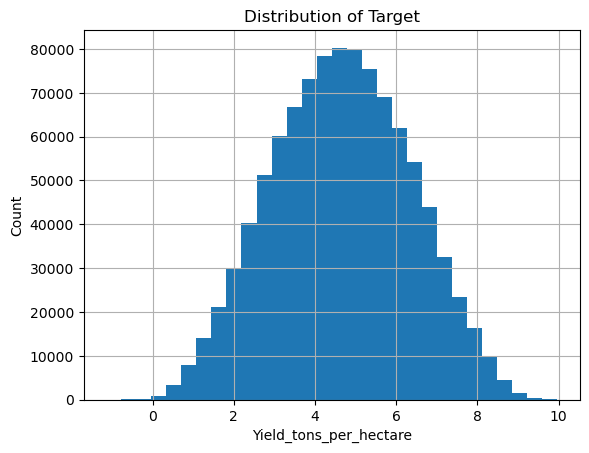

In [6]:
plt.figure()
df[COLS["target"]].hist(bins=30)
plt.title("Distribution of Target")
plt.xlabel(COLS["target"])
plt.ylabel("Count")
plt.show()


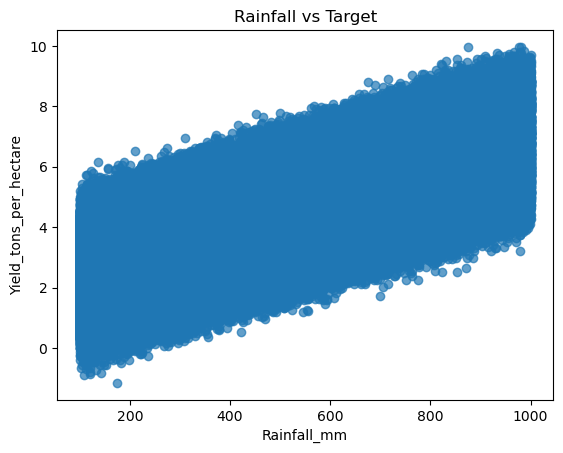

In [7]:
if COLS["rain"] in df.columns:
    plt.figure()
    plt.scatter(df[COLS["rain"]], df[COLS["target"]], alpha=0.7)
    plt.title("Rainfall vs Target")
    plt.xlabel(COLS["rain"])
    plt.ylabel(COLS["target"])
    plt.show()


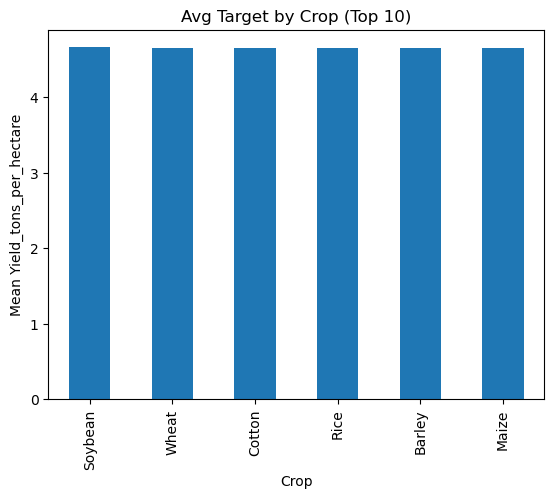

In [8]:
if COLS["crop"] in df.columns:
    agg = df.groupby(COLS["crop"])[COLS["target"]].mean().sort_values(ascending=False).head(10)
    plt.figure()
    agg.plot(kind="bar")
    plt.title("Avg Target by Crop (Top 10)")
    plt.xlabel(COLS["crop"])
    plt.ylabel(f"Mean {COLS['target']}")
    plt.show()


In [9]:
def one_hot_variant(X_train, X_test, y_train, y_test, cat_cols, num_cols, bin_cols, scaler, scaler_name, out_prefix):
    num_pipe = Pipeline(steps=[
        ("impute", SimpleImputer(strategy="median")),
        ("scale", scaler),
    ])
    cat_pipe = Pipeline(steps=[
        ("impute", SimpleImputer(strategy="most_frequent")),
        ("ohe", OneHotEncoder(handle_unknown="ignore", sparse=False)),
    ])
    
    transformers = []
    if num_cols:
        transformers.append(("num", num_pipe, num_cols))
    if cat_cols:
        transformers.append(("cat", cat_pipe, cat_cols))
    if bin_cols:
        transformers.append(("bin", "passthrough", bin_cols))

    ct = ColumnTransformer(transformers=transformers, remainder="drop")

    Xtr = ct.fit_transform(X_train, y_train)
    Xte = ct.transform(X_test)

    feat_names = []
    if num_cols:
        feat_names.extend([f"{c}__{scaler_name}" for c in num_cols])
    if cat_cols:
        ohe = ct.named_transformers_["cat"].named_steps["ohe"]
        ohe_names = ohe.get_feature_names_out(cat_cols).tolist()
        feat_names.extend(ohe_names)
    if bin_cols:
        feat_names.extend(bin_cols)

    Xtr_df = pd.DataFrame(Xtr, columns=feat_names, index=X_train.index)
    Xte_df = pd.DataFrame(Xte, columns=feat_names, index=X_test.index)

    Xtr_df["target"] = y_train.values
    Xte_df["target"] = y_test.values

    train_path = OUT_DIR / f"{out_prefix}_train.csv"
    test_path  = OUT_DIR / f"{out_prefix}_test.csv"
    Xtr_df.to_csv(train_path, index=False)
    Xte_df.to_csv(test_path, index=False)

    with open(OUT_DIR / f"{out_prefix}_column_transformer.pkl", "wb") as f:
        pickle.dump(ct, f)

    with open(OUT_DIR / f"{out_prefix}_scaler.pkl", "wb") as f:
        pickle.dump(scaler, f)

    meta = {
        "variant": out_prefix,
        "cat_cols": cat_cols,
        "num_cols": num_cols,
        "bin_cols": bin_cols,
        "feature_names": feat_names,
    }
    with open(OUT_DIR / f"{out_prefix}_meta.json", "w") as f:
        json.dump(meta, f, indent=2)

    return train_path, test_path


In [10]:
def looe_variant(X_train, X_test, y_train, y_test, cat_cols, num_cols, bin_cols, scaler, scaler_name, out_prefix):
    Xtr = X_train.copy()
    Xte = X_test.copy()

    if num_cols:
        imp_num = SimpleImputer(strategy="median")
        Xtr[num_cols] = imp_num.fit_transform(Xtr[num_cols])
        Xte[num_cols] = imp_num.transform(Xte[num_cols])

    if cat_cols:
        imp_cat = SimpleImputer(strategy="most_frequent")
        Xtr[cat_cols] = imp_cat.fit_transform(Xtr[cat_cols])
        Xte[cat_cols] = imp_cat.transform(Xte[cat_cols])

    if cat_cols:
        looe = LeaveOneOutEncoder(cols=cat_cols)
        Xtr_cat = looe.fit_transform(Xtr[cat_cols], y_train)
        Xte_cat = looe.transform(Xte[cat_cols])
    else:
        looe = None
        Xtr_cat = pd.DataFrame(index=Xtr.index)
        Xte_cat = pd.DataFrame(index=Xte.index)

    if num_cols:
        scaler_fitted = scaler.fit(Xtr[num_cols])
        Xtr_num = pd.DataFrame(scaler_fitted.transform(Xtr[num_cols]), columns=[f"{c}__{scaler_name}" for c in num_cols], index=Xtr.index)
        Xte_num = pd.DataFrame(scaler_fitted.transform(Xte[num_cols]), columns=[f"{c}__{scaler_name}" for c in num_cols], index=Xte.index)
    else:
        scaler_fitted = scaler
        Xtr_num = pd.DataFrame(index=Xtr.index)
        Xte_num = pd.DataFrame(index=Xte.index)

    Xtr_bin = Xtr[bin_cols] if bin_cols else pd.DataFrame(index=Xtr.index)
    Xte_bin = Xte[bin_cols] if bin_cols else pd.DataFrame(index=Xte.index)

    Xtr_final = pd.concat([Xtr_num, Xtr_cat, Xtr_bin], axis=1)
    Xte_final = pd.concat([Xte_num, Xte_cat, Xte_bin], axis=1)

    Xtr_final["target"] = y_train.values
    Xte_final["target"] = y_test.values

    train_path = OUT_DIR / f"{out_prefix}_train.csv"
    test_path  = OUT_DIR / f"{out_prefix}_test.csv"
    Xtr_final.to_csv(train_path, index=False)
    Xte_final.to_csv(test_path, index=False)

    if looe is not None:
        with open(OUT_DIR / f"{out_prefix}_looe.pkl", "wb") as f:
            pickle.dump(looe, f)

    with open(OUT_DIR / f"{out_prefix}_scaler.pkl", "wb") as f:
        pickle.dump(scaler_fitted, f)

    meta = {
        "variant": out_prefix,
        "cat_cols": cat_cols,
        "num_cols": num_cols,
        "bin_cols": bin_cols,
        "feature_names": Xtr_final.columns.tolist(),
    }
    with open(OUT_DIR / f"{out_prefix}_meta.json", "w") as f:
        json.dump(meta, f, indent=2)

    return train_path, test_path


In [11]:
print("CAT:", CAT_COLS)
print("NUM:", NUMERIC_CONT_COLS)
print("BIN:", BINARY_COLS)

paths = {}

train_p, test_p = one_hot_variant(
    X_train, X_test, y_train, y_test,
    cat_cols=CAT_COLS, num_cols=NUMERIC_CONT_COLS, bin_cols=BINARY_COLS,
    scaler=StandardScaler(), scaler_name="std", out_prefix="ohe_std"
)
paths["ohe_std"] = (str(train_p), str(test_p))

train_p, test_p = one_hot_variant(
    X_train, X_test, y_train, y_test,
    cat_cols=CAT_COLS, num_cols=NUMERIC_CONT_COLS, bin_cols=BINARY_COLS,
    scaler=MinMaxScaler(), scaler_name="mm", out_prefix="ohe_mm"
)
paths["ohe_mm"] = (str(train_p), str(test_p))

train_p, test_p = looe_variant(
    X_train, X_test, y_train, y_test,
    cat_cols=CAT_COLS, num_cols=NUMERIC_CONT_COLS, bin_cols=BINARY_COLS,
    scaler=StandardScaler(), scaler_name="std", out_prefix="looe_std"
)
paths["looe_std"] = (str(train_p), str(test_p))

train_p, test_p = looe_variant(
    X_train, X_test, y_train, y_test,
    cat_cols=CAT_COLS, num_cols=NUMERIC_CONT_COLS, bin_cols=BINARY_COLS,
    scaler=MinMaxScaler(), scaler_name="mm", out_prefix="looe_mm"
)
paths["looe_mm"] = (str(train_p), str(test_p))

paths


CAT: ['Region', 'Soil_Type', 'Crop', 'Weather_Condition']
NUM: ['Rainfall_mm', 'Temperature_Celsius', 'Days_to_Harvest']
BIN: ['Fertilizer_Used', 'Irrigation_Used']


c:\Users\ACER\anaconda3\envs\myenv\lib\site-packages\sklearn\preprocessing\_encoders.py:972: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
c:\Users\ACER\anaconda3\envs\myenv\lib\site-packages\sklearn\preprocessing\_encoders.py:972: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


{'ohe_std': ('outputs_variants\\ohe_std_train.csv',
  'outputs_variants\\ohe_std_test.csv'),
 'ohe_mm': ('outputs_variants\\ohe_mm_train.csv',
  'outputs_variants\\ohe_mm_test.csv'),
 'looe_std': ('outputs_variants\\looe_std_train.csv',
  'outputs_variants\\looe_std_test.csv'),
 'looe_mm': ('outputs_variants\\looe_mm_train.csv',
  'outputs_variants\\looe_mm_test.csv')}

In [ ]:
pip install xgboost lightgbm catboost


Note: you may need to restart the kernel to use updated packages.


In [13]:
import pandas as pd
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor

models = {
    "LinearRegression": LinearRegression(),
    "Ridge": Ridge(),
    "Lasso": Lasso(),
    "XGBoost": XGBRegressor(
        tree_method="gpu_hist", 
        predictor="gpu_predictor", 
        random_state=42, 
        n_estimators=300
    ),
    "LightGBM": LGBMRegressor(
        device="gpu", 
        random_state=42, 
        n_estimators=300
    ),
    "CatBoost": CatBoostRegressor(
        task_type="GPU", 
        random_state=42, 
        verbose=0, 
        iterations=300
    )
}

variants = ["ohe_std", "ohe_mm", "looe_std", "looe_mm"]
results = []

for variant in variants:
    train_path = OUT_DIR / f"{variant}_train.csv"
    test_path  = OUT_DIR / f"{variant}_test.csv"

    train_df = pd.read_csv(train_path)
    test_df = pd.read_csv(test_path)

    X_train = train_df.drop(columns=["target"])
    y_train = train_df["target"]
    X_test = test_df.drop(columns=["target"])
    y_test = test_df["target"]

    for model_name, model in models.items():
        print(f"Training {model_name} on {variant}...")

        model.fit(X_train, y_train)
        preds = model.predict(X_test)

        r2 = r2_score(y_test, preds)
        mae = mean_absolute_error(y_test, preds)
        mse = mean_squared_error(y_test, preds)
        rmse = mse**0.5

        results.append({
            "variant": variant,
            "model": model_name,
            "R2": r2,
            "MAE": mae,
            "MSE": mse,
            "RMSE": rmse
        })

results_df = pd.DataFrame(results).sort_values(by="R2", ascending=False).reset_index(drop=True)
results_df


Training LinearRegression on ohe_std...
Training Ridge on ohe_std...
Training Lasso on ohe_std...
Training XGBoost on ohe_std...


c:\Users\ACER\anaconda3\envs\myenv\lib\site-packages\xgboost\core.py:158: UserWarning: [19:42:34] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\common\error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
c:\Users\ACER\anaconda3\envs\myenv\lib\site-packages\xgboost\core.py:158: UserWarning: [19:42:35] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "predictor" } are not used.

  warnings.warn(smsg, UserWarning)
c:\Users\ACER\anaconda3\envs\myenv\lib\site-packages\xgboost\core.py:158: UserWarning: [19:47:35] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\

Training LightGBM on ohe_std...


c:\Users\ACER\anaconda3\envs\myenv\lib\site-packages\joblib\externals\loky\backend\context.py:136: UserWarning: Could not find the number of physical cores for the following reason:
[WinError 2] The system cannot find the file specified
Returning the number of logical cores instead. You can silence this warning by setting LOKY_MAX_CPU_COUNT to the number of cores you want to use.
  warnings.warn(
  File "c:\Users\ACER\anaconda3\envs\myenv\lib\site-packages\joblib\externals\loky\backend\context.py", line 257, in _count_physical_cores
    cpu_info = subprocess.run(
  File "c:\Users\ACER\anaconda3\envs\myenv\lib\subprocess.py", line 493, in run
    with Popen(*popenargs, **kwargs) as process:
  File "c:\Users\ACER\anaconda3\envs\myenv\lib\subprocess.py", line 858, in __init__
    self._execute_child(args, executable, preexec_fn, close_fds,
  File "c:\Users\ACER\anaconda3\envs\myenv\lib\subprocess.py", line 1327, in _execute_child
    hp, ht, pid, tid = _winapi.CreateProcess(executable, ar

[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 643
[LightGBM] [Info] Number of data points in the train set: 800000, number of used features: 24
[LightGBM] [Info] Using GPU Device: NVIDIA GeForce RTX 4050 Laptop GPU, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 9 dense feature groups (9.16 MB) transferred to GPU in 1.090517 secs. 0 sparse feature groups
[LightGBM] [Info] Start training from score 4.649019
Training CatBoost on ohe_std...
Training LinearRegression on ohe_mm...
Training Ridge on ohe_mm...
Training Lasso on ohe_mm...
Training XGBoost on ohe_mm...


c:\Users\ACER\anaconda3\envs\myenv\lib\site-packages\xgboost\core.py:158: UserWarning: [20:07:21] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\common\error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
c:\Users\ACER\anaconda3\envs\myenv\lib\site-packages\xgboost\core.py:158: UserWarning: [20:07:21] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "predictor" } are not used.

  warnings.warn(smsg, UserWarning)
c:\Users\ACER\anaconda3\envs\myenv\lib\site-packages\xgboost\core.py:158: UserWarning: [20:07:25] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\

Training LightGBM on ohe_mm...
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 642
[LightGBM] [Info] Number of data points in the train set: 800000, number of used features: 24
[LightGBM] [Info] Using GPU Device: NVIDIA GeForce RTX 4050 Laptop GPU, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 9 dense feature groups (9.16 MB) transferred to GPU in 0.021376 secs. 0 sparse feature groups
[LightGBM] [Info] Start training from score 4.649019
Training CatBoost on ohe_mm...
Training LinearRegression on looe_std...
Training Ridge on looe_std...
Training Lasso on looe_std...
Training XGBoost on looe_std...


c:\Users\ACER\anaconda3\envs\myenv\lib\site-packages\xgboost\core.py:158: UserWarning: [20:07:45] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\common\error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
c:\Users\ACER\anaconda3\envs\myenv\lib\site-packages\xgboost\core.py:158: UserWarning: [20:07:45] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "predictor" } are not used.

  warnings.warn(smsg, UserWarning)
c:\Users\ACER\anaconda3\envs\myenv\lib\site-packages\xgboost\core.py:158: UserWarning: [20:07:48] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\

Training LightGBM on looe_std...
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 1625
[LightGBM] [Info] Number of data points in the train set: 800000, number of used features: 9
[LightGBM] [Info] Using GPU Device: NVIDIA GeForce RTX 4050 Laptop GPU, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 9 dense feature groups (9.16 MB) transferred to GPU in 0.020886 secs. 0 sparse feature groups
[LightGBM] [Info] Start training from score 4.649019
Training CatBoost on looe_std...
Training LinearRegression on looe_mm...
Training Ridge on looe_mm...
Training Lasso on looe_mm...
Training XGBoost on looe_mm...


c:\Users\ACER\anaconda3\envs\myenv\lib\site-packages\xgboost\core.py:158: UserWarning: [20:08:09] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\common\error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
c:\Users\ACER\anaconda3\envs\myenv\lib\site-packages\xgboost\core.py:158: UserWarning: [20:08:09] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "predictor" } are not used.

  warnings.warn(smsg, UserWarning)
c:\Users\ACER\anaconda3\envs\myenv\lib\site-packages\xgboost\core.py:158: UserWarning: [20:08:13] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\

Training LightGBM on looe_mm...
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 1624
[LightGBM] [Info] Number of data points in the train set: 800000, number of used features: 9
[LightGBM] [Info] Using GPU Device: NVIDIA GeForce RTX 4050 Laptop GPU, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 9 dense feature groups (9.16 MB) transferred to GPU in 0.021730 secs. 0 sparse feature groups
[LightGBM] [Info] Start training from score 4.649019
Training CatBoost on looe_mm...


,variant,model,R2,MAE,MSE,RMSE
0,ohe_std,Ridge,0.913014,0.399554,0.250777,0.500776
1,ohe_mm,Ridge,0.913014,0.399554,0.250777,0.500776
2,looe_std,Ridge,0.913014,0.399555,0.250777,0.500776
3,looe_mm,Ridge,0.913014,0.399555,0.250777,0.500776
4,looe_std,LinearRegression,0.913013,0.399557,0.250779,0.500778
5,looe_mm,LinearRegression,0.913013,0.399557,0.250779,0.500778
6,ohe_mm,LinearRegression,0.913013,0.399561,0.250779,0.500779
7,ohe_std,LinearRegression,0.913006,0.399578,0.250798,0.500798
8,ohe_mm,LightGBM,0.912804,0.400047,0.251382,0.501380
9,ohe_mm,CatBoost,0.912804,0.400012,0.251382,0.501380


    variant             model        R2       MAE       MSE      RMSE
0   ohe_std             Ridge  0.913014  0.399554  0.250777  0.500776
1    ohe_mm             Ridge  0.913014  0.399554  0.250777  0.500776
2  looe_std             Ridge  0.913014  0.399555  0.250777  0.500776
3   looe_mm             Ridge  0.913014  0.399555  0.250777  0.500776
4  looe_std  LinearRegression  0.913013  0.399557  0.250779  0.500778


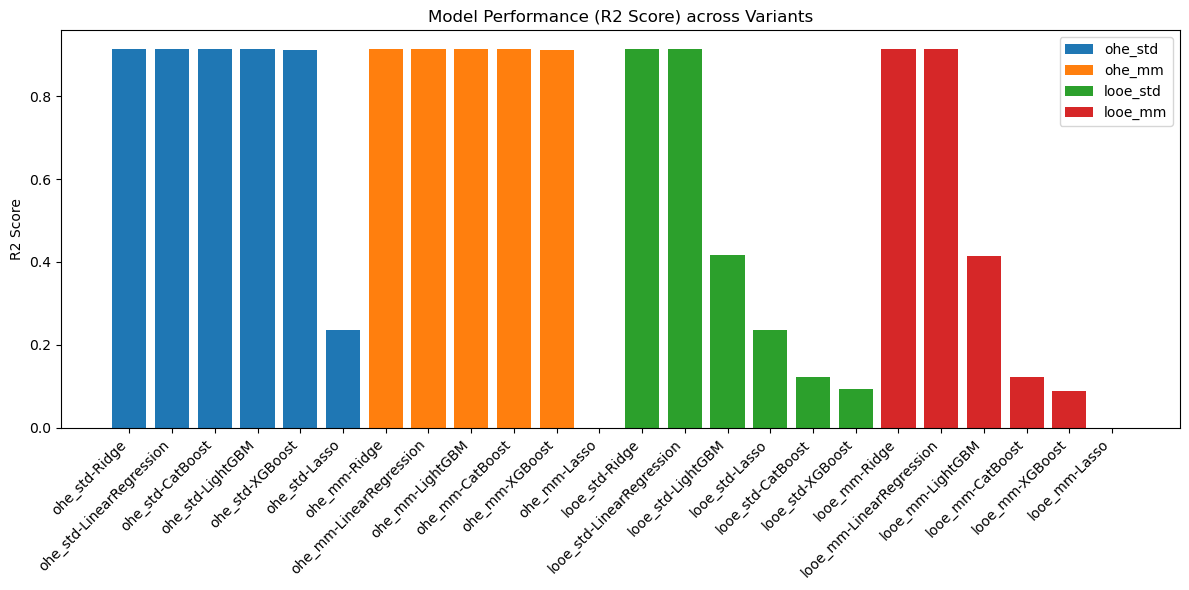

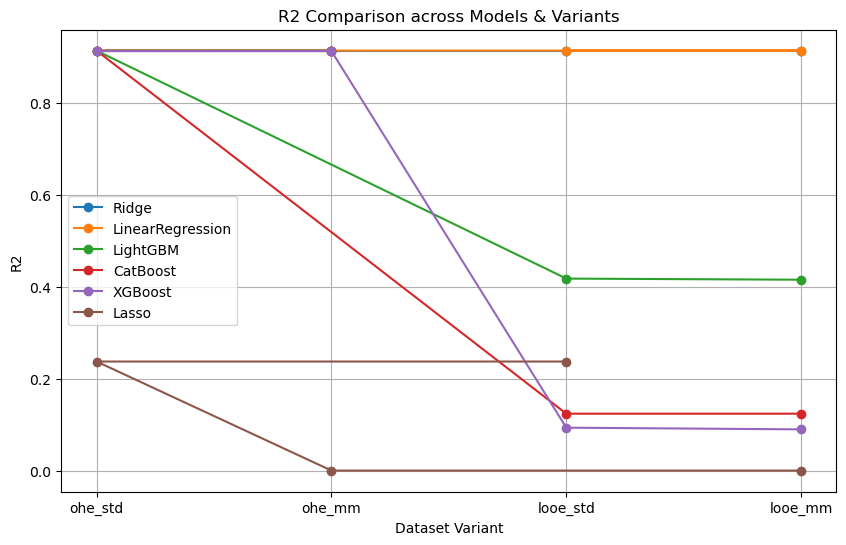

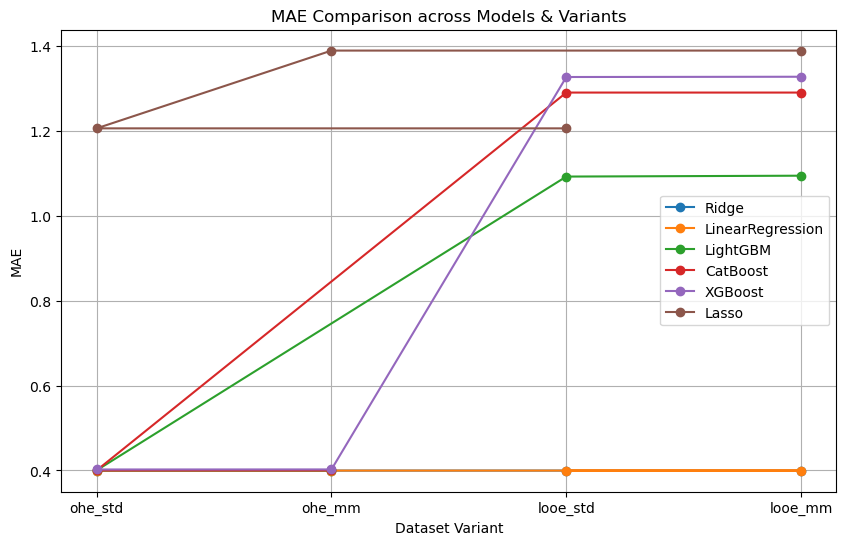

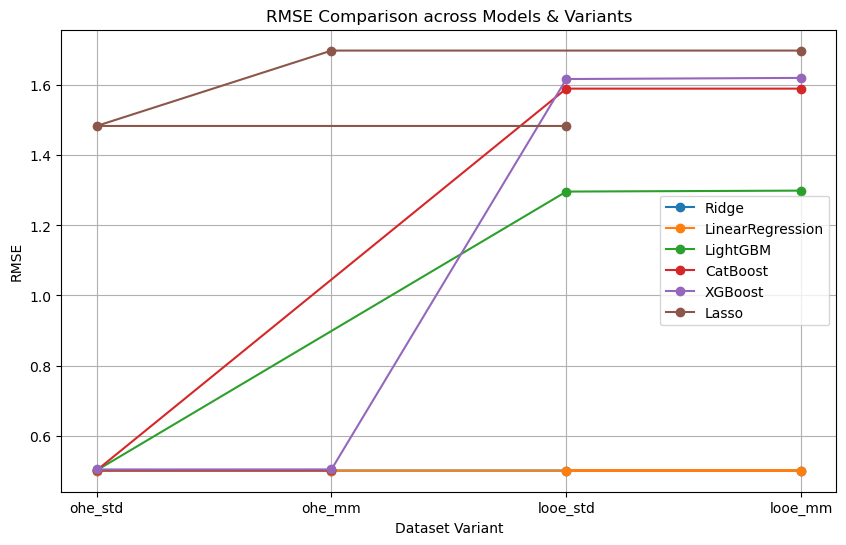

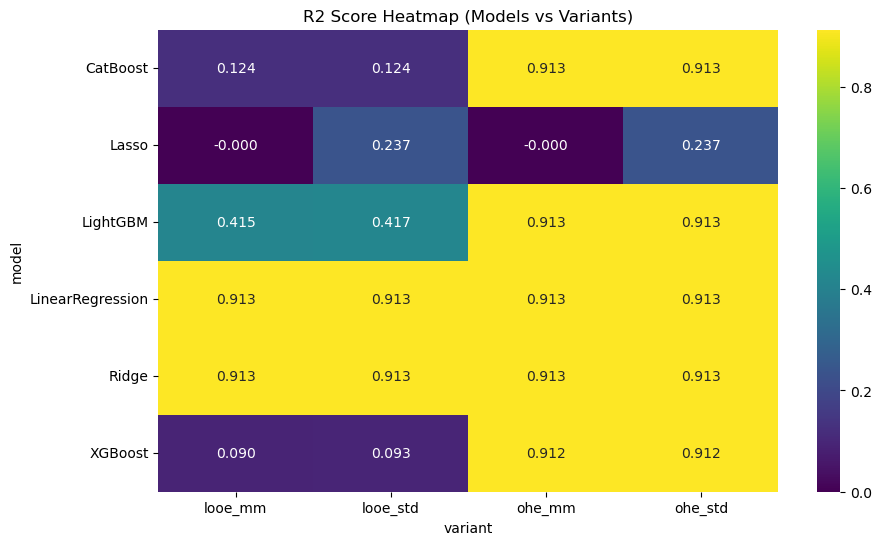

In [14]:
import matplotlib.pyplot as plt

print(results_df.head())

plt.figure(figsize=(12,6))
for variant in results_df["variant"].unique():
    subset = results_df[results_df["variant"] == variant]
    plt.bar(
        [f"{variant}-{m}" for m in subset["model"]],
        subset["R2"],
        label=variant
    )

plt.xticks(rotation=45, ha="right")
plt.ylabel("R2 Score")
plt.title("Model Performance (R2 Score) across Variants")
plt.legend()
plt.tight_layout()
plt.show()

metrics = ["R2", "MAE", "RMSE"]

for metric in metrics:
    plt.figure(figsize=(10,6))
    for model in results_df["model"].unique():
        subset = results_df[results_df["model"] == model]
        plt.plot(subset["variant"], subset[metric], marker="o", label=model)
    
    plt.title(f"{metric} Comparison across Models & Variants")
    plt.xlabel("Dataset Variant")
    plt.ylabel(metric)
    plt.legend()
    plt.grid(True)
    plt.show()

import seaborn as sns

pivot_r2 = results_df.pivot(index="model", columns="variant", values="R2")
plt.figure(figsize=(10,6))
sns.heatmap(pivot_r2, annot=True, cmap="viridis", fmt=".3f")
plt.title("R2 Score Heatmap (Models vs Variants)")
plt.show()
